## ***Sub-problem 5:*** Correlation between the general climate of a county with the health of its population and availability of pharmacies.

Get Files

In [1]:
!wget -nc https://raw.githubusercontent.com/ravi-raj-97/big_data_pharmacy_county/main/Pharmacy-County.xlsx
!wget -nc https://raw.githubusercontent.com/ravi-raj-97/big_data_pharmacy_county/main/Demography_USA.xlsx
# !wget -nc https://raw.githubusercontent.com/ravi-raj-97/big_data_pharmacy_county/ashish/uszips.csv

--2022-05-09 20:44:27--  https://raw.githubusercontent.com/ravi-raj-97/big_data_pharmacy_county/main/Pharmacy-County.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2173314 (2.1M) [application/octet-stream]
Saving to: ‘Pharmacy-County.xlsx’

Pharmacy-County.xls 100%[===================>]   2.07M  --.-KB/s    in 0.03s   

2022-05-09 20:44:28 (71.2 MB/s) - ‘Pharmacy-County.xlsx’ saved [2173314/2173314]

--2022-05-09 20:44:28--  https://raw.githubusercontent.com/ravi-raj-97/big_data_pharmacy_county/main/Demography_USA.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request

Form dataframes

In [2]:
import pandas as pd

In [3]:
pharmacy_county=pd.ExcelFile("Pharmacy-County.xlsx")
demography_usa=pd.ExcelFile("Demography_USA.xlsx")

In [4]:
pharmacy_county.sheet_names[0:5]

['Alaska', 'Arkansas', 'California', 'Colarado', 'Connecticut']

In [5]:
demography_usa.sheet_names[:6]

['Demography USA', 'Population', 'Housing', 'Households', 'Ages', 'Genders']

In [6]:
pharmacy_county_statewise={}

for state in pharmacy_county.sheet_names:
  pharmacy_county_statewise[state]=pd.io.excel.ExcelFile.parse(pharmacy_county, state).drop(0)

In [7]:
pharmacy_county_statewise.keys()

dict_keys(['Alaska', 'Arkansas', 'California', 'Colarado', 'Connecticut', 'Delaware', 'Flordia', 'Hawaii', 'Idaho', 'Kansas', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Jersey', 'North Carolina', 'North Dakota', 'Oklahoma', 'Oregon', 'Rhode island', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Wisconsin', 'Other State'])

In [8]:
demography_usa_categories={}

demography_usa_categories['Climate']=pd.io.excel.ExcelFile.parse(demography_usa, 'Demography USA')
demography_usa_categories['Population']=pd.io.excel.ExcelFile.parse(demography_usa, 'Population')
demography_usa_categories['Diseases']=pd.io.excel.ExcelFile.parse(demography_usa, 'Diseases')

In [9]:
demography_usa_categories.keys()

dict_keys(['Climate', 'Population', 'Diseases'])



---

## 1. Correlation between the general climate of a county with the health of its population

In [10]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

Create joined dataframe and splitting into test and train sets

In [11]:
print(demography_usa_categories['Diseases'].shape)
print(demography_usa_categories['Climate'].shape)

(3219, 16)
(3219, 12)


In [12]:
demography_disease_climate=demography_usa_categories['Diseases'].merge(demography_usa_categories['Climate'],on=['OBJECTID'],how='inner',suffixes=('', '_y'))
demography_disease_climate.drop(demography_disease_climate.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

In [13]:
demography_disease_climate.shape

(3219, 23)

In [14]:
demography_disease_climate['IECC_Zone']=demography_disease_climate['IECC Climate Zone'].astype(str)+demography_disease_climate['IECC Moisture Regime']

In [18]:
demography_disease_climate.dropna()
demography_disease_climate.shape

(3219, 24)

In [19]:
# split into test and train datasets
demography_disease_climate_train,demography_disease_climate_test=train_test_split(demography_disease_climate,train_size=0.7)

In [20]:
print(demography_disease_climate_train.shape)
print(demography_disease_climate_test.shape)

(2253, 24)
(966, 24)


In [21]:
feature_columns=['Prevalence of obesity', 'Hypertension', 'Diabetes', 'CVD', 'HIV/AIDS', 'cvd_100k', 'hypertension_100k']
class_columns=['IECC_Zone']

In [22]:
# split into feature and label matrices/vectors
x_train=demography_disease_climate_train[feature_columns].values
x_test=demography_disease_climate_test[feature_columns].values

y_train=demography_disease_climate_train[class_columns].apply(lambda col: pd.factorize(col, sort=True)[0]).values
y_test=demography_disease_climate_test[class_columns].apply(lambda col: pd.factorize(col, sort=True)[0]).values

In [23]:
y_train

array([[11],
       [12],
       [ 7],
       ...,
       [ 1],
       [ 7],
       [ 6]])

Correlation Heatmap

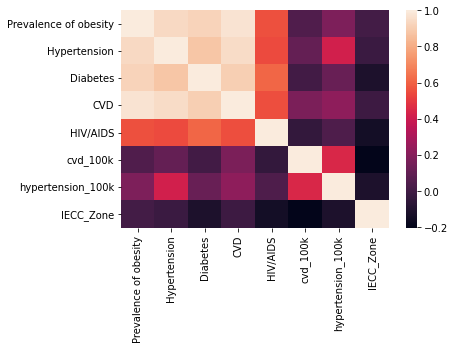

In [34]:
# Generate a heatmap that depicts correlation between the features
import seaborn as sns
%matplotlib inline
columns=['Prevalence of obesity', 'Hypertension', 'Diabetes', 'CVD', 'HIV/AIDS', 'cvd_100k', 'hypertension_100k', 'IECC_Zone']
demography_disease_climate_corr = demography_disease_climate[columns].apply(lambda col: pd.factorize(col, sort=True)[0]).corr()
sns.heatmap(demography_disease_climate_corr, 
        xticklabels=columns,
        yticklabels=columns)

Using SVM

In [ ]:
result_string=[]
# k is the number of principal components
for k in range(1,len(feature_columns)+1):
  svm = make_pipeline(StandardScaler(), PCA(n_components=k), SVC(gamma='auto'),)
  _=svm.fit(x_train,y_train.ravel())
  score=svm.score(x_test,y_test.ravel())
  result_string.append(f"num_features = {k} : {score}")

In [ ]:
for result in result_string:
  print(result)

num_features = 1 : 0.2329192546583851
num_features = 2 : 0.2587991718426501
num_features = 3 : 0.3250517598343685
num_features = 4 : 0.37267080745341613
num_features = 5 : 0.36438923395445133
num_features = 6 : 0.35714285714285715
num_features = 7 : 0.34886128364389235


Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# restricting max features that can be split on
svm = make_pipeline(StandardScaler(), DecisionTreeClassifier(max_features=4))
_=svm.fit(x_train,y_train)
score=svm.score(x_test,y_test)

In [ ]:
print(score)

0.30745341614906835


In [ ]:
max_score=0
depth=1
# k is the max depth allowed
for k in range(1,100):
  tree = make_pipeline(StandardScaler(), DecisionTreeClassifier(max_depth=k))
  _=tree.fit(x_train,y_train)
  score=tree.score(x_test,y_test)
  if score>max_score:
    max_score=score
    depth=k
print(f"depth = {depth} : score = {max_score}")

depth = 7 : score = 0.3581780538302277


Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
max_score=0
depth=1
# k is the max depth allowed
for k in range(1,len(feature_columns)+1):
  tree = make_pipeline(StandardScaler(), RandomForestClassifier(max_depth=k))
  _=tree.fit(x_train,y_train.ravel())
  score=tree.score(x_test,y_test.ravel())
  if score>max_score:
    max_score=score
    depth=k
print(f"depth = {depth} : score = {max_score}")

depth = 7 : score = 0.38716356107660455


Multi Layer Perceptron

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
max_score=0
num_features=1
# k is number of principal components
for k in range(1,len(feature_columns)+1):
  nn = make_pipeline(StandardScaler(), PCA(n_components=k), MLPClassifier(random_state=1, max_iter=10000))
  _=nn.fit(x_train,y_train.ravel())
  score=nn.score(x_test,y_test.ravel())
  if score>max_score:
    max_score=score
    num_features=k
print(f"num_features = {num_features} : score = {max_score}")

num_features = 5 : score = 0.41200828157349895


Conclusion:

*Using various classifiers, a maximum test score of 41.2% could be achieved which indicates that there is weak or no correlation between thee health of the county and the climate*

---

## 2. Correlation between Climate of the county and number of pharmacies

In [35]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

Create joined dataframe and splitting into test and train sets

In [36]:
print(pharmacy_county_statewise['Alaska'].shape)
print(demography_usa_categories['Climate'].shape)

(121, 6)
(3219, 12)


In [37]:
states_with_county_info = ['Alaska', 'Arkansas', 'California', 'Hawaii', 'Idaho', 'Maine', 'Missouri', 'Montana',
 'Nebraska', 'North Carolina', 'Oregon', 'Rhode island', 'Texas']

In [38]:
for state in states_with_county_info:
  pharmacy_county_statewise[state]['county']=pharmacy_county_statewise[state]['county'].str.lower()

In [39]:
# Removing terms like 'county' and 'borough' from the county names
for state in states_with_county_info:
  for ix in pharmacy_county_statewise[state].index:
      county_name = pharmacy_county_statewise[state].loc[ix]['county']
      if ' city and borough' in county_name:
          county_name_new = county_name.replace(' city and borough', '')
          pharmacy_county_statewise[state]['county'] = pharmacy_county_statewise[state]['county'].replace(county_name, county_name_new)
      elif ' county' in county_name:
          county_name_new = county_name.replace(' county', '')
          pharmacy_county_statewise[state]['county'] = pharmacy_county_statewise[state]['county'].replace(county_name, county_name_new)
      elif ' borough' in county_name:
          county_name_new = county_name.replace(' borough','')
          pharmacy_county_statewise[state]['county'] = pharmacy_county_statewise[state]['county'].replace(county_name, county_name_new)
      elif ' municipality' in county_name:
          county_name_new = county_name.replace(' municipality','')
          pharmacy_county_statewise[state]['county'] = pharmacy_county_statewise[state]['county'].replace(county_name, county_name_new)
      elif ' city' in county_name:
          county_name_new = county_name.replace(' city','')
          pharmacy_county_statewise[state]['county'] = pharmacy_county_statewise[state]['county'].replace(county_name, county_name_new)
      elif ' census area' in county_name:
          county_name_new = county_name.replace(' census area','')
          pharmacy_county_statewise[state]['county'] = pharmacy_county_statewise[state]['county'].replace(county_name, county_name_new)

In [40]:
pharmacy_county_statewise['Texas'].groupby(by='county').agg('count')['State']

county
anderson     7
andrews      3
angelina    13
aransas      4
archer       1
            ..
wood         9
yoakum       2
young        5
zapata       2
zavala       2
Name: State, Length: 225, dtype: int64

In [41]:
# Create a dataframe with the state, county names and the number of pharmacies in each county
num_pharmacy_county_wise=[]

for state in states_with_county_info:
  num_pharmacy_county=pharmacy_county_statewise[state].groupby(by='county').agg('count')['State']
  for county in num_pharmacy_county.keys():
    num_pharmacy_county_wise.append([state,county,num_pharmacy_county[county]])

num_pharmacy_county_wise=pd.DataFrame(num_pharmacy_county_wise, columns=["STATE_NAME","County Name","Num_Pharmacies"])

In [42]:
num_pharmacy_county_wise

,STATE_NAME,County Name,Num_Pharmacies
0,Alaska,anchorage,51
1,Alaska,city and of juneau,1
2,Alaska,dillingham,1
3,Alaska,fairbanks north star,13
4,Alaska,haines,1
...,...,...,...
805,Texas,wood,9
806,Texas,yoakum,2
807,Texas,young,5
808,Texas,zapata,2


In [43]:
demography_usa_categories['Climate']['County Name']=demography_usa_categories['Climate']['County Name'].str.lower()

In [44]:
# Join the two dataframes
pharmacy_count_climate=pd.merge(demography_usa_categories['Climate'],num_pharmacy_county_wise,on=['STATE_NAME','County Name'],suffixes=('', '_y'))
pharmacy_count_climate.drop(pharmacy_count_climate.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

In [45]:
pharmacy_count_climate

,OBJECTID,NAME,County Name,STATE_NAME,State,STATE_FIPS,CNTY_FIPS,FIPS,IECC Climate Zone,IECC Moisture Regime,BA Climate Zone,Temp,Num_Pharmacies
0,2958,Anchorage,anchorage,Alaska,AK,2,20,2020,7,NaN,Very Cold,1733.300624,51
1,3179,Haines,haines,Alaska,AK,2,100,2100,7,NaN,Very Cold,2367.380199,1
2,3181,Juneau,juneau,Alaska,AK,2,110,2110,7,NaN,Very Cold,2761.022564,6
3,3184,Fairbanks North Star,fairbanks north star,Alaska,AK,2,90,2090,8,NaN,Subarctic,7435.314794,13
4,3194,Matanuska-Susitna,matanuska-susitna,Alaska,AK,2,170,2170,7,NaN,Very Cold,24976.167683,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,3129,Cameron,cameron,Texas,TX,48,61,48061,2,A,Hot-Humid,949.719526,73
794,3131,Matagorda,matagorda,Texas,TX,48,321,48321,2,A,Hot-Humid,1140.332862,8
795,3153,Nueces,nueces,Texas,TX,48,355,48355,2,A,Hot-Humid,844.128000,55
796,3157,Aransas,aransas,Texas,TX,48,7,48007,2,A,Hot-Humid,263.740586,4


In [46]:
pharmacy_count_climate['IECC_Zone']=pharmacy_count_climate['IECC Climate Zone'].astype(str)+pharmacy_count_climate['IECC Moisture Regime']

In [47]:
pharmacy_count_climate=pharmacy_count_climate.dropna()
pharmacy_count_climate

,OBJECTID,NAME,County Name,STATE_NAME,State,STATE_FIPS,CNTY_FIPS,FIPS,IECC Climate Zone,IECC Moisture Regime,BA Climate Zone,Temp,Num_Pharmacies,IECC_Zone
19,703,Cleburne,cleburne,Arkansas,AR,5,23,5023,3,A,Mixed-Humid,591.920155,7,3A
20,929,Boone,boone,Arkansas,AR,5,9,5009,4,A,Mixed-Humid,601.756172,7,4A
21,936,Cross,cross,Arkansas,AR,5,37,5037,3,A,Mixed-Humid,622.348691,5,3A
22,1285,Searcy,searcy,Arkansas,AR,5,129,5129,4,A,Mixed-Humid,668.532626,2,4A
23,1307,Columbia,columbia,Arkansas,AR,5,27,5027,3,A,Hot-Humid,766.630310,5,3A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,3129,Cameron,cameron,Texas,TX,48,61,48061,2,A,Hot-Humid,949.719526,73,2A
794,3131,Matagorda,matagorda,Texas,TX,48,321,48321,2,A,Hot-Humid,1140.332862,8,2A
795,3153,Nueces,nueces,Texas,TX,48,355,48355,2,A,Hot-Humid,844.128000,55,2A
796,3157,Aransas,aransas,Texas,TX,48,7,48007,2,A,Hot-Humid,263.740586,4,2A


In [48]:
# Spltting the data into training and test sets
pharmacy_count_climate_train,pharmacy_count_climate_test=train_test_split(pharmacy_count_climate,train_size=0.7)

In [49]:
print(pharmacy_count_climate_train.shape)
print(pharmacy_count_climate_test.shape)

(544, 14)
(234, 14)


Preprocess

In [50]:
feature_columns=['Num_Pharmacies']
class_columns=['IECC_Zone']#,'IECC Climate Zone', 'IECC Moisture Regime', 'BA Climate Zone', 'Temp']

In [51]:
# Splitting the data into feature and label sets
x_train=pharmacy_count_climate_train[feature_columns].values
x_test=pharmacy_count_climate_test[feature_columns].values

y_train=pharmacy_count_climate_train[class_columns].apply(lambda col: pd.factorize(col, sort=True)[0]).values
y_test=pharmacy_count_climate_test[class_columns].apply(lambda col: pd.factorize(col, sort=True)[0]).values

Correlation Heatmap

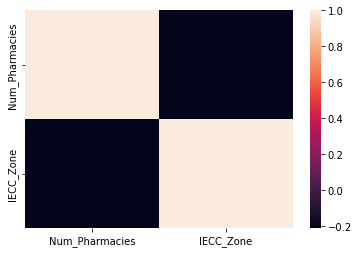

In [52]:
# Generate a heatmap of the correlation matrix
import seaborn as sns
%matplotlib inline
columns=['Num_Pharmacies', 'IECC_Zone']
pharmacy_count_climate_corr = pharmacy_count_climate[columns].apply(lambda col: pd.factorize(col, sort=True)[0]).corr()
sns.heatmap(pharmacy_count_climate_corr, 
        xticklabels=columns,
        yticklabels=columns)

Decision Trees

In [141]:
from sklearn.tree import DecisionTreeClassifier

In [142]:
svm = make_pipeline(StandardScaler(), DecisionTreeClassifier())
_=svm.fit(x_train,y_train)
score=svm.score(x_test,y_test)

In [143]:
print(score)

0.1794871794871795


In [144]:
max_score=0
depth=1
# k is the max depth allowed
for k in range(1,100):
  tree = make_pipeline(StandardScaler(), DecisionTreeClassifier(max_depth=k))
  _=tree.fit(x_train,y_train)
  score=tree.score(x_test,y_test)
  if score>max_score:
    max_score=score
    depth=k
print(f"depth = {depth} : score = {max_score}")

depth = 2 : score = 0.23504273504273504


Random Forest

In [145]:
from sklearn.ensemble import RandomForestClassifier

In [146]:
max_score=0
depth=1
# k is the max depth allowed
for k in range(1,len(feature_columns)+1):
  tree = make_pipeline(StandardScaler(), RandomForestClassifier(max_depth=k))
  _=tree.fit(x_train,y_train.ravel())
  score=tree.score(x_test,y_test.ravel())
  if score>max_score:
    max_score=score
    depth=k
print(f"depth = {depth} : score = {max_score}")

depth = 1 : score = 0.2264957264957265


Logistic Regression

In [147]:
from sklearn.linear_model import LogisticRegression

In [148]:
clf = LogisticRegression(random_state=0).fit(x_train, y_train.ravel())
clf.score(x_test,y_test.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.2222222222222222

```Logistic regression classifier fails to converge```

Conclusion:

*Using various classifiers, a maximum test score of 23.5% could be achieved which indicates that there is weak or no correlation between thee number of pharmacies in a county and its climate*